# Определение перспективного тарифа для телеком-компании.

**Описание проекта**  
Мы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.  
Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов.  
В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.  

`Описание тарифов:`

`Тариф «Смарт»`
Ежемесячная плата: 550 рублей  
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:  
минута разговора: 3 рубля  
сообщение: 3 рубля  
1 Гб интернет-трафика: 200 рублей  


`Тариф «Ультра»`
Ежемесячная плата: 1950 рублей  
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:  
минута разговора: 1 рубль  
сообщение: 1 рубль  
1 Гб интернет-трафика: 150 рублей  

`Примечание`:  
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.  
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в большую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Шаг 1. Откроем файл с данными и изучим общую информацию

#### Импортируем библиотеки, изучим данные таблицы с тарифами `tariffs.csv`

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as mt

from scipy import stats as st

pd.options.display.float_format = '{:.2f}'.format

tariffs = pd.read_csv('/datasets/tariffs.csv', sep=',')

display(tariffs.info())
display(tariffs.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.00,2.00,2.00,2.00,2.00,2.00,2.00
mean,525.00,23040.00,1750.00,1250.00,175.00,2.00,2.00
std,671.75,10861.16,1767.77,989.95,35.36,1.41,1.41
min,50.00,15360.00,500.00,550.00,150.00,1.00,1.00
25%,287.50,19200.00,1125.00,900.00,162.50,1.50,1.50
50%,525.00,23040.00,1750.00,1250.00,175.00,2.00,2.00
75%,762.50,26880.00,2375.00,1600.00,187.50,2.50,2.50
max,1000.00,30720.00,3000.00,1950.00,200.00,3.00,3.00


Определим нулевые значения в столбцах

In [ ]:
display('Количество нулевых значений:', tariffs.isin([0]).sum())

'Количество нулевых значений:'

messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64

Найдем минимальные и максимальные значения

In [ ]:
display(tariffs.min())
display(tariffs.max())

messages_included           50
mb_per_month_included    15360
minutes_included           500
rub_monthly_fee            550
rub_per_gb                 150
rub_per_message              1
rub_per_minute               1
tariff_name              smart
dtype: object

messages_included         1000
mb_per_month_included    30720
minutes_included          3000
rub_monthly_fee           1950
rub_per_gb                 200
rub_per_message              3
rub_per_minute               3
tariff_name              ultra
dtype: object

Посмотрим структуру данных

In [ ]:
display(tariffs.head())

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Вывод:  
- В таблице 2 строки, 8 столбцов
- Пояснения для `tariffs` (информация о тарифах):
    - tariff_name — название тарифа (тип object)
    - rub_monthly_fee — ежемесячная абонентская плата в рублях (тип int64)
    - minutes_included — количество минут разговора в месяц, включённых в абонентскую плату (тип int64)
    - messages_included — количество сообщений в месяц, включённых в абонентскую плату (тип int64)
    - mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах) (тип int64)
    - rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата) (тип int64)
    - rub_per_message — стоимость отправки сообщения сверх тарифного пакета (тип int64)
    - rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта) (тип int64)


#### Изучим таблицу `users.csv`

In [ ]:
users = pd.read_csv('/datasets/users.csv', sep=',')

display(users.info())
display(users.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

,user_id,age
count,500.00,500.00
mean,1249.50,46.59
std,144.48,16.67
min,1000.00,18.00
25%,1124.75,32.00
50%,1249.50,46.00
75%,1374.25,62.00
max,1499.00,75.00


Определим нулевые значения в столбцах

In [ ]:
display('Нулевые значения обнаружены:', users.isin([0]).sum())

'Нулевые значения обнаружены:'

user_id       0
age           0
churn_date    0
city          0
first_name    0
last_name     0
reg_date      0
tariff        0
dtype: int64

Найдем минимальные и максимальные значения

In [ ]:
display(users.min())
display(users.max())

user_id              1000
age                    18
city          Архангельск
first_name      Авксентий
last_name          Ёлчина
reg_date       2018-01-01
tariff              smart
dtype: object

user_id             1499
age                   75
city           Ярославль
first_name           Яна
last_name          Яшина
reg_date      2018-12-31
tariff             ultra
dtype: object

Определим количество дублей

In [ ]:
print('Количество дублей', users.duplicated().sum())

Количество дублей 0


Посмотрим структуру данных

In [ ]:
display(users.head())

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Вывод:  
- В таблице 500 строк, 8 столбцов
- Пояснения для таблицы `users` (информация о пользователях):
    - user_id — уникальный идентификатор пользователя (тип - int64)
    - age — возраст пользователя (годы) (тип - int64)
    - churn_date — дата прекращения пользования тарифом (тип - object)
    - city — город проживания пользователя (тип - object)
    - first_name — имя пользователя (тип - object)
    - last_name — фамилия пользователя (тип - object)
    - reg_date — дата подключения тарифа (день, месяц, год) (тип - object)
    - tariff — название тарифного плана (тип - object)  
    
Необходимо будет изменить в `churn_date` и `reg_date` тип данных на date.  

462 пропущенных значений в столбце `churn_date` трогать не будем (если значение пропущено, то тариф ещё действовал на момент выгрузки данных).

#### Изучим таблицу `calls.csv`

In [ ]:
calls = pd.read_csv('/datasets/calls.csv', sep=',')

display(calls.info())
display(calls.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

,duration,user_id
count,202607.00,202607.00
mean,6.76,1253.94
std,5.84,144.72
min,0.00,1000.00
25%,1.30,1126.00
50%,6.00,1260.00
75%,10.70,1379.00
max,38.00,1499.00


Определим нулевые значения в столбцах

In [ ]:
display('Нулевые значения обнаружены:', calls.isin([0]).sum())

'Нулевые значения обнаружены:'

id               0
call_date        0
duration     39613
user_id          0
dtype: int64

Найдем минимальные и максимальные значения

In [ ]:
display(calls.min())
display(calls.max())

id               1000_0
call_date    2018-01-01
duration           0.00
user_id            1000
dtype: object

id              1499_99
call_date    2018-12-31
duration          38.00
user_id            1499
dtype: object

Определим количество дублей

In [ ]:
print('Количество дублей', calls.duplicated().sum())

Количество дублей 0


Оценим структуру данных

In [ ]:
display(calls.head())

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Вывод:  
- В таблице 202607 строк, 4 столбца
- Пояснения для таблицы `calls` (информация о звонках):
    - id — уникальный номер звонка (тип - object)
    - call_date — дата звонка (тип - object)
    - duration — длительность звонка в минутах (тип - float64)
    - user_id — идентификатор пользователя, сделавшего звонок (тип - int64)  

Значения `call_date` необходимо привести к типу date.  

Учитывая, что «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута - необходимо будет поменять в `duration` тип с float на integer. Значения пропущены в 39613 случаях, можно предположить что исходящий звонок совершался, гудки шли, но абонент не отвечал. Для подтвеждения теории можно запросить ответственного за выгрузку данных сотрудника пояснить этот момент, как рассчитывается. Можно заменить пропуски на среднее значение длительности звонка по `user_id`.


#### Изучим таблицу `internet.csv`

In [ ]:
internet = pd.read_csv('/datasets/internet.csv', sep=',')

display(internet.info())
display(internet.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

,Unnamed: 0,mb_used,user_id
count,149396.00,149396.00,149396.00
mean,74697.50,370.19,1252.10
std,43127.05,278.30,144.05
min,0.00,0.00,1000.00
25%,37348.75,138.19,1130.00
50%,74697.50,348.01,1251.00
75%,112046.25,559.55,1380.00
max,149395.00,1724.83,1499.00


Определим нулевые значения в столбцах

In [ ]:
display('Нулевые значения обнаружены:', internet.isin([0]).sum())

'Нулевые значения обнаружены:'

Unnamed: 0          1
id                  0
mb_used         19598
session_date        0
user_id             0
dtype: int64

Найдем минимальные и максимальные значения

In [ ]:
display(internet.min())
display(internet.max())

Unnamed: 0               0
id                  1000_0
mb_used               0.00
session_date    2018-01-01
user_id               1000
dtype: object

Unnamed: 0          149395
id                 1499_99
mb_used            1724.83
session_date    2018-12-31
user_id               1499
dtype: object

Определим количество дублей

In [ ]:
print('Количество дублей', internet.duplicated().sum())

Количество дублей 0


Оценим структуру данных

In [ ]:
display(internet.head())

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Вывод:  
- В таблице 149396 строк, 5 столбцов
- Пояснения для таблицы `internet` ((информация об интернет-сессиях):
    - Unnamed: 0 (тип - int64)
    - id — уникальный номер сессии (тип - object)
    - mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах) (тип - float64)
    - session_date — дата интернет-сессии (тип - object)
    - user_id — идентификатор пользователя (тип - int64)  

Не понятный столбец с названием `Unnamed: 0`, возможно продублировался. Неоходимо запросить информацию у человека, выгружавшего данные из базы. На данном этапе можно будет удалить его.  
В столбце `mb_used` необходимо будет округлить данные, изменить тип с `float` на `int`. В этом же столбце обнаружены пропуски 19598 штук, их можно будет заменить на среднее значение объёма потраченного за сессию интернет-трафика по user_id.  
В столбце `session_date` тип данных необходимо заменить на date.

#### Изучим таблицу `messages.csv`

In [ ]:
messages = pd.read_csv('/datasets/messages.csv', sep=',')

display(messages.info())
display(messages.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

,user_id
count,123036.00
mean,1256.99
std,143.52
min,1000.00
25%,1134.00
50%,1271.00
75%,1381.00
max,1499.00


Определим нулевые значения в столбцах


In [ ]:
display('Нулевые значения обнаружены:', messages.isin([0]).sum())

'Нулевые значения обнаружены:'

id              0
message_date    0
user_id         0
dtype: int64

Найдем минимальные и максимальные значения

In [ ]:
display(messages.min())
display(messages.max())

id                  1000_0
message_date    2018-01-02
user_id               1000
dtype: object

id                 1499_99
message_date    2018-12-31
user_id               1499
dtype: object

Определим количество дублей

In [ ]:
print('Количество дублей', messages.duplicated().sum())

Количество дублей 0


Оценим структуру данных

In [ ]:
display(messages.head())

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Вывод:  
- В таблице 123036 строк, 3 столбца
- Пояснения для таблицы `users` (информация о сообщениях):
    - id — уникальный номер сообщения (тип - object)
    - message_date — дата сообщения (тип - object)
    - user_id — идентификатор пользователя, отправившего сообщение (тип - int64)  

В столбце `message_date` данные необходимо привести к типу date.  
Пропусков нету.

## Шаг 2. Подготовим данные

### Обработаем пропуски и удалим ненужных данные

Удалим столбец **Unnamed: 0**

In [ ]:
internet.drop('Unnamed: 0', axis=1, inplace = True)

### Приведем данные к нужным типам

Обработка таблицы `users.csv`. Изменим тип данных в столбцах **churn_date** и **reg_date**

In [ ]:
users['churn_date']= pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date']= pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

Обработка таблицы `calls.csv`. Изменим тип данных в столбцах **call_date**

In [ ]:
calls['call_date']= pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

Обработка таблицы `internet.csv`. Изменим тип данных в столбцах **session_date**

In [ ]:
internet['session_date']= pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

Обработка таблицы `messages.csv`. Изменим тип данных в столбцах **session_date**

In [ ]:
messages['message_date']= pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

### Категоризация данных

Обработка таблицы `users.csv`. Произведем категоризацию данных столбца **city**. Создадим словарь city_dict и добавим туда **id**

In [ ]:
city_dict = (users[['city']]
                      .dropna()
                      .sort_values(by = 'city', ascending = True)
                      .drop_duplicates(subset='city').reset_index(drop = True)
)

city_dict['city_id'] = city_dict.reset_index().index

Перенесем в таблицу `users` столбцы **city_id**

In [ ]:
users = users.merge(city_dict, on='city', how='left')

Сформируем итоговую таблицу с нужными категориями, назовем ее `users_updated`

In [ ]:
users_updated = users[['user_id','age','churn_date','city_id','first_name','last_name','reg_date','tariff']]

### Вычислим и добавим данные в таблицы

Посчитаем для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам.  
Добавим столбец **month** в таблицу `calls`

In [ ]:
calls['month'] = calls['call_date'].dt.month

Создадим сводную таблицу `calls_pivot` с вычисленными полями **calls_made** и **minutes_used**

In [ ]:
calls_pivot = (calls.
    pivot_table(index=['user_id','month'], values='duration', aggfunc=['count', 'sum']).
    sort_values(by = ['user_id','month'], ascending = True)
)
calls_pivot.columns = ['calls_made','minutes_used']
calls_pivot.reset_index(inplace = True)

Вычислим для каждого пользователя количество отправленных сообщений по месяцам.  
Добавим столбец **month** в таблицу `messages`

In [ ]:
messages['month'] = messages['message_date'].dt.month

Создадим сводную таблицу `messages_pivot` с вычисленным полем **messages_used** (количество отправленных сообщений по месяцам)

In [ ]:
messages_pivot = (messages.
    pivot_table(index=['user_id','month'], values='id', aggfunc='count').
    sort_values(by = ['user_id','month'], ascending = True)
)

messages_pivot.columns = ['messages_used']
messages_pivot.reset_index(inplace = True)

Вычислим для каждого пользователя бъем израсходованного интернет-трафика по месяцам.  
Добавим столбец **month** в таблицу `internet`

In [ ]:
internet['month'] = internet['session_date'].dt.month

Создадим сводную таблицу `messages_pivot` с вычисленным полем **mb_used** (объем израсходованного интернет-трафика по месяцам)

In [ ]:
internet_pivot = (internet.
    pivot_table(index=['user_id','month'], values='mb_used', aggfunc='sum').
    sort_values(by = ['user_id','month'], ascending = True)
)

internet_pivot.columns = ['mb_used']
internet_pivot.reset_index(inplace = True)

Посчитаем для каждого пользователя помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану)  

Сделаем общую таблицу `calls_messages_internet`

In [ ]:
calls_messages_internet = pd.merge((pd.merge(calls_pivot, messages_pivot, how='outer', on=['user_id', 'month'])), internet_pivot, how='outer', on=['user_id', 'month'])

Добавим в таблицу `calls_messages_internet` строку **tariff** из таблицы `users` по **user_id**

In [ ]:
calls_messages_internet = calls_messages_internet.merge(users_updated[['tariff','user_id']], on = 'user_id', how='left')

Добавим в таблицу `calls_messages_internet` данные тарифных планов из таблицы `tariffs`

In [ ]:
calls_messages_internet = calls_messages_internet.join(tariffs.set_index('tariff_name'), on='tariff')

Заменим `NaN` на нулевые значения

In [ ]:
calls_messages_internet.fillna(value=0, inplace = True)

Определим помесячную выручку для каждого пользователя.  
Посчитаем перерасход минут, сообщений и мегабайт (вычтем из бесплатных лимитов фактический расход, в случае наличия неизрасходованных ед. услуг в полях overrun ставим 0)

In [ ]:
calls_messages_internet['minutes_overrun'] = (calls_messages_internet['minutes_included']-(calls_messages_internet['minutes_used']))*(-1)
calls_messages_internet['minutes_overrun'] = calls_messages_internet['minutes_overrun'].where(calls_messages_internet['minutes_overrun'] >= 0, 0)
calls_messages_internet['messages_overrun'] = (calls_messages_internet['messages_included']-(calls_messages_internet['messages_used']))*(-1)
calls_messages_internet['messages_overrun'] = calls_messages_internet['messages_overrun'].where(calls_messages_internet['messages_overrun'] >= 0, 0)
calls_messages_internet['mb_overrun'] = (calls_messages_internet['mb_per_month_included']-(calls_messages_internet['mb_used']))*(-1)
calls_messages_internet['mb_overrun'] = calls_messages_internet['mb_overrun'].where(calls_messages_internet['mb_overrun'] >= 0, 0)
calls_messages_internet['gb_overrun'] = np.ceil(calls_messages_internet.mb_overrun / 1024).astype(int)

Определим выручку по формуле "стоимость перерасхода плюс абонентская плата".  
При конвертации мегабайт в гигабайты, значение последних округлим в большую сторону, т.к. обычно объем сверх лимита продается по-гигабайтно.  
Пример: пользователь потратил 4484 мегабайт сверх лимита (4,38 Гб), но заплатит за 5 Гб.

In [ ]:
calls_messages_internet['total_revenue'] = (
    calls_messages_internet['minutes_overrun'] * calls_messages_internet['rub_per_minute'] +
    calls_messages_internet['messages_overrun'] * calls_messages_internet['rub_per_message'] +
    np.ceil(calls_messages_internet.mb_overrun / 1024).astype(int) * calls_messages_internet['rub_per_gb'] +
    calls_messages_internet['rub_monthly_fee']
)

## Шаг 3. Проанализируем данные


- Опишем поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?  
- Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы. Опишем распределения.

Изучим следующие параметры: количество использованных минут, сообщений и объем интернет-траффика. Построем гистограммы для каждого параметра.  
Сформируем таблицу со столбцами **tariff, minutes_used, messages_used, mb_used, minutes_included,messages_included, mb_per_month_included, rub_monthly_fee, total_revenue**

In [ ]:
calls_messages_internet_analysis = calls_messages_internet[['tariff', 'minutes_used', 'messages_used', 'mb_used','total_revenue']]
calls_messages_internet_analysis_smart = calls_messages_internet_analysis.query('tariff == "smart"')
calls_messages_internet_analysis_ultra = calls_messages_internet_analysis.query('tariff == "ultra"')

Посмотрим на данные пользователей по месяцам

In [ ]:
display('Данные по пользователям тарифа smart:', calls_messages_internet_analysis_smart.describe())
display('Данные по пользователям тарифа ultra:',calls_messages_internet_analysis_ultra.describe())

'Данные по пользователям тарифа smart:'

,minutes_used,messages_used,mb_used,total_revenue
count,2229.00,2229.00,2229.00,2229.00
mean,394.43,33.38,16208.39,1257.16
std,179.96,28.23,5870.48,800.72
min,0.00,0.00,0.00,550.00
25%,267.23,10.00,12643.01,550.00
50%,397.98,28.00,16506.84,961.67
75%,515.07,51.00,20042.93,1731.86
max,1354.22,143.00,38552.45,6613.10


'Данные по пользователям тарифа ultra:'

,minutes_used,messages_used,mb_used,total_revenue
count,985.00,985.00,985.00,985.00
mean,497.07,49.36,19468.81,2070.15
std,299.90,47.80,10087.17,376.19
min,0.00,0.00,0.00,1950.00
25%,267.75,6.00,11770.26,1950.00
50%,488.10,38.00,19308.01,1950.00
75%,711.47,79.00,26837.69,1950.00
max,1578.06,224.00,49745.69,4800.00


Посмотрим на усредненного пользователя по обоим тарифам


In [ ]:
calls_messages_internet_analysis_pivot = calls_messages_internet_analysis.pivot_table(index='tariff', values=['minutes_used', 'messages_used', 'mb_used','total_revenue'], aggfunc='mean')
calls_messages_internet_analysis_pivot.columns = ['mb_used_mean', 'messages_used_mean','minutes_used_mean','total_revenue_mean']
display('Данные по усредненному пользователю:', calls_messages_internet_analysis_pivot)

'Данные по усредненному пользователю:'

,mb_used_mean,messages_used_mean,minutes_used_mean,total_revenue_mean
tariff,,,,
smart,16208.39,33.38,394.43,1257.16
ultra,19468.81,49.36,497.07,2070.15


Посчитаем дисперсию по имеющейся выборке и стандартное отклонение

In [ ]:
variance_estimate_smart = np.var(calls_messages_internet_analysis_smart, ddof=1)
standard_deviation_smart = np.std(calls_messages_internet_analysis_smart, ddof=1)
display('Средние значение по тарифу smart', calls_messages_internet_analysis_smart.mean())
display('Дисперсия по выборке по тарифу smart:', variance_estimate_smart)
display('Стандартное отклонение по выборке по тарифу smart:', standard_deviation_smart)

variance_estimate_ultra = np.var(calls_messages_internet_analysis_ultra, ddof=1)
standard_deviation_ultra = np.std(calls_messages_internet_analysis_ultra, ddof=1)
display('Средние значение по тарифу ultra', calls_messages_internet_analysis_ultra.mean())
display('Дисперсия по выборке по тарифу ultra:', variance_estimate_ultra)
display('Стандартное отклонение по тарифу ultra:', standard_deviation_ultra)

'Средние значение по тарифу smart'

minutes_used      394.43
messages_used      33.38
mb_used         16208.39
total_revenue    1257.16
dtype: float64

'Дисперсия по выборке по тарифу smart:'

minutes_used       32386.40
messages_used        796.81
mb_used         34462496.46
total_revenue     641149.07
dtype: float64

'Стандартное отклонение по выборке по тарифу smart:'

minutes_used     179.96
messages_used     28.23
mb_used         5870.48
total_revenue    800.72
dtype: float64

'Средние значение по тарифу ultra'

minutes_used      497.07
messages_used      49.36
mb_used         19468.81
total_revenue    2070.15
dtype: float64

'Дисперсия по выборке по тарифу ultra:'

minutes_used        89942.50
messages_used        2285.27
mb_used         101751013.78
total_revenue      141516.75
dtype: float64

'Стандартное отклонение по тарифу ultra:'

minutes_used      299.90
messages_used      47.80
mb_used         10087.17
total_revenue     376.19
dtype: float64

Посчитаем значения по правилу трех сигм для тарифа smart

In [ ]:
three_sigma_minutes_used_smart = 394.43 + 3 * 179.96
three_sigma_messages_used_smart = 49.36 + 3 * 47.80
three_sigma_mb_used_smart = 19468.81 + 3 * 5870.48
three_sigma_total_revenue_smart = 1257.16 + 3 * 800.72
print('Правило трех сигм (minutes_used_smart):',three_sigma_minutes_used_smart)
print('Правило трех сигм (messages_used_smart):',three_sigma_messages_used_smart)
print('Правило трех сигм (mb_used_smart):',three_sigma_mb_used_smart)
print('Правило трех сигм (total_revenue_smart):',three_sigma_total_revenue_smart)

Правило трех сигм (minutes_used_smart): 934.31
Правило трех сигм (messages_used_smart): 192.76
Правило трех сигм (mb_used_smart): 37080.25
Правило трех сигм (total_revenue_smart): 3659.3199999999997


Посчитаем значения по правилу трех сигм для тарифа ultra

In [ ]:
three_sigma_minutes_used_ultra = 497.07 + 3 * 299.90
three_sigma_messages_used_ultra = 49.36 + 3 * 47.80
three_sigma_mb_used_ultra = 19468.81 + 3 * 10087.17
three_sigma_total_revenue_ultra = 2070.15 + 3 * 376.19
print('Правило трех сигм (minutes_used_ultra):',three_sigma_minutes_used_ultra)
print('Правило трех сигм (messages_used_ultra):',three_sigma_messages_used_ultra)
print('Правило трех сигм (mb_used_ultra):',three_sigma_mb_used_ultra)
print('Правило трех сигм (total_revenue_ultra):',three_sigma_total_revenue_ultra)

Правило трех сигм (minutes_used_ultra): 1396.77
Правило трех сигм (messages_used_ultra): 192.76
Правило трех сигм (mb_used_ultra): 49730.32000000001
Правило трех сигм (total_revenue_ultra): 3198.7200000000003


Автоматизируем построение гистограмм для тарифа smart

Гистограммы тарифа smart


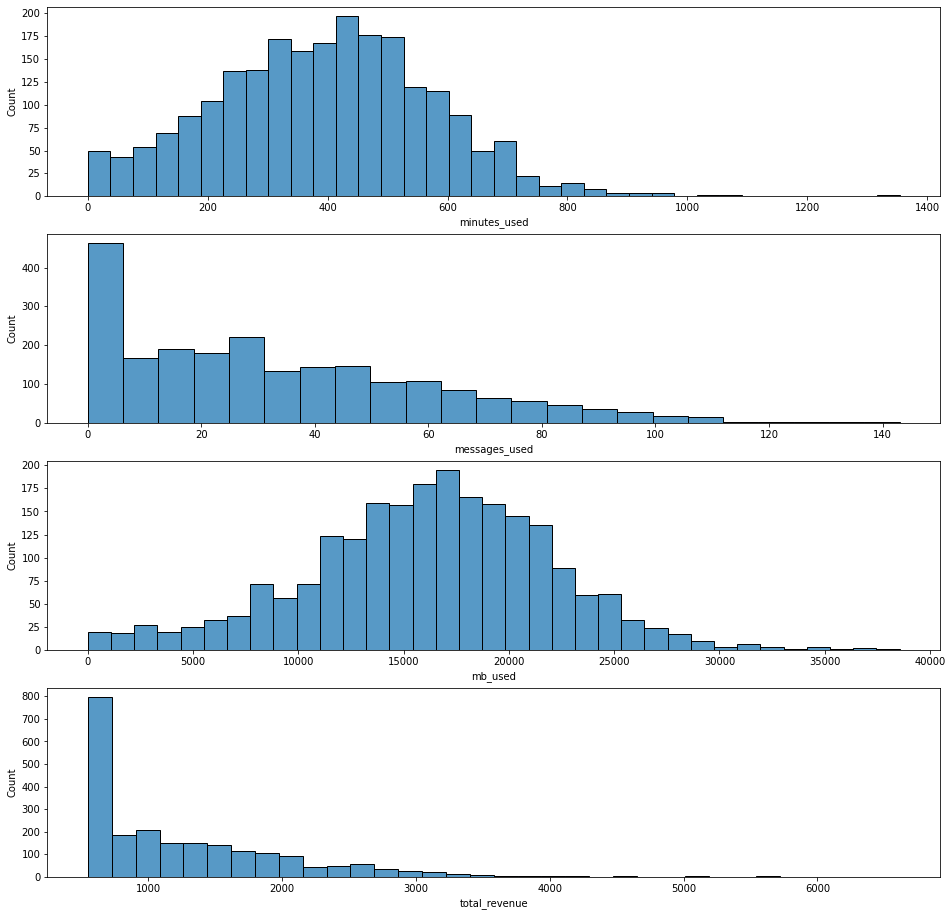

In [ ]:
print('Гистограммы тарифа smart')
count = 0
for columns in calls_messages_internet_analysis_smart:
    columnSeriesObj = calls_messages_internet_analysis_smart[columns]
    if columnSeriesObj.dtypes != object:
            count +=1
fig,axes=plt.subplots(count, figsize=(16,16))

counter = -1
for columns in calls_messages_internet_analysis_smart:
    columnSeriesObj = calls_messages_internet_analysis_smart[columns]
    if columnSeriesObj.dtypes != object:
        counter += 1
        try:
            sns.histplot(columnSeriesObj, ax=axes[counter])
        except:
            sns.histplot(columnSeriesObj, ax=axes[counter], kde=False)


Автоматизируем построение гистограмм для тарифа ultra

Гистограммы тарифа ultra


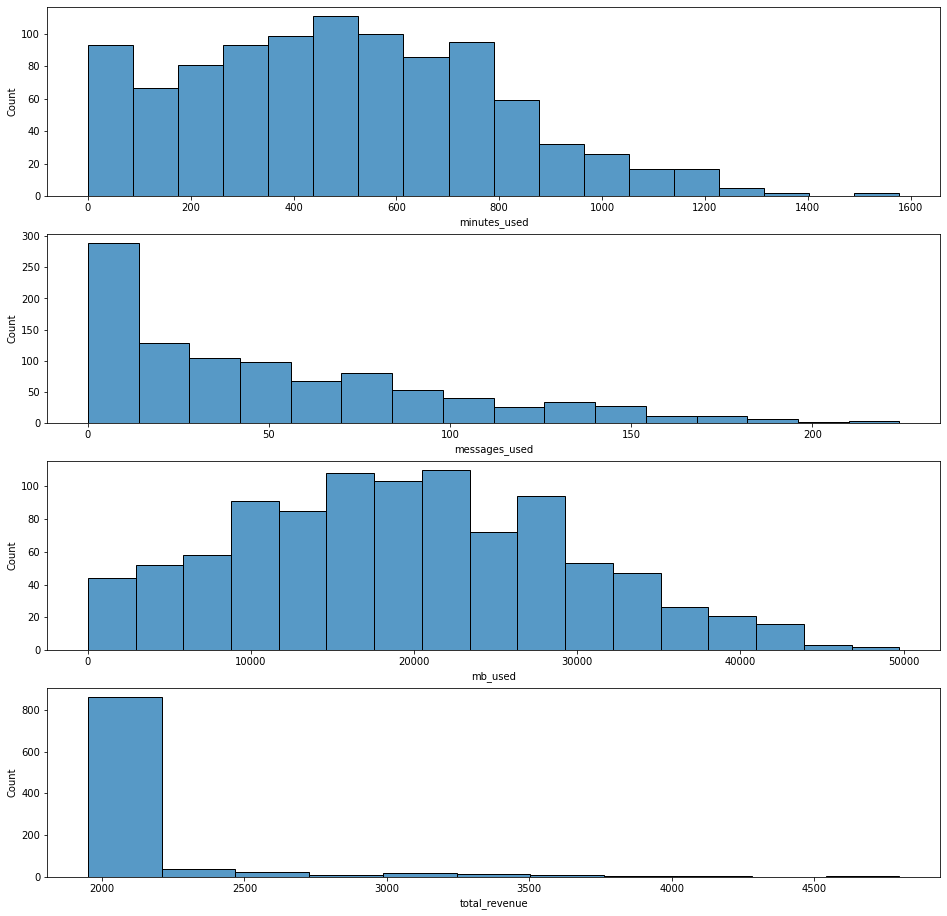

In [ ]:
print('Гистограммы тарифа ultra')
count = 0
for columns in calls_messages_internet_analysis_ultra:
    columnSeriesObj = calls_messages_internet_analysis_ultra[columns]
    if columnSeriesObj.dtypes != object:
            count +=1
fig,axes=plt.subplots(count, figsize=(16,16))

counter = -1
for columns in calls_messages_internet_analysis_ultra:
    columnSeriesObj = calls_messages_internet_analysis_ultra[columns]
    if columnSeriesObj.dtypes != object:
        counter += 1
        try:
            sns.histplot(columnSeriesObj, ax=axes[counter])
        except:

            sns.histplot(columnSeriesObj, ax=axes[counter], kde=False)

Построим совмещенные гистграммы для тарифов smart и ultra (для наглядности)

<AxesSubplot:ylabel='Frequency'>

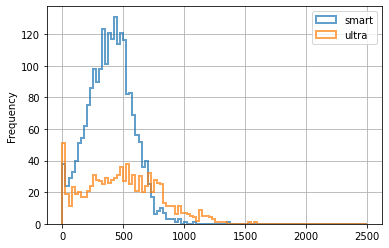

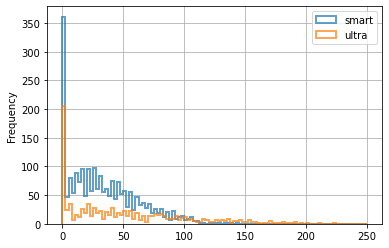

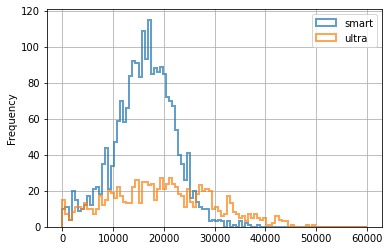

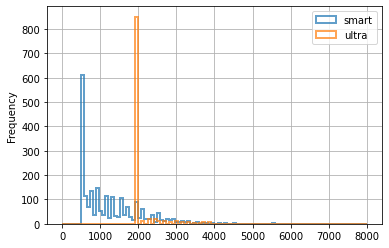

In [ ]:
ax_minutes_used_smart = calls_messages_internet_analysis_smart.plot(kind='hist', y='minutes_used', histtype='step', range=(0, 2500), bins=100, linewidth=2, alpha=0.7, label='smart')
ax_messages_used_smart = calls_messages_internet_analysis_smart.plot(kind='hist', y='messages_used', histtype='step', range=(0, 250), bins=100, linewidth=2, alpha=0.7, label='smart')
ax_mb_used_smart = calls_messages_internet_analysis_smart.plot(kind='hist', y='mb_used', histtype='step', range=(0, 60000), bins=100, linewidth=2, alpha=0.7, label='smart')
ax_total_revenue_smart = calls_messages_internet_analysis_smart.plot(kind='hist', y='total_revenue', histtype='step', range=(0, 8000), bins=100, linewidth=2, alpha=0.7, label='smart')

calls_messages_internet_analysis_ultra.plot(kind='hist', y='minutes_used', histtype='step', range=(0, 2500), bins=100, linewidth=2, alpha=0.7, label='ultra', ax=ax_minutes_used_smart, grid=True, legend=True)
calls_messages_internet_analysis_ultra.plot(kind='hist', y='messages_used', histtype='step', range=(0, 250), bins=100, linewidth=2, alpha=0.7, label='ultra', ax=ax_messages_used_smart, grid=True, legend=True)
calls_messages_internet_analysis_ultra.plot(kind='hist', y='mb_used', histtype='step', range=(0, 60000), bins=100, linewidth=2, alpha=0.7, label='ultra', ax=ax_mb_used_smart, grid=True, legend=True)
calls_messages_internet_analysis_ultra.plot(kind='hist', y='total_revenue', histtype='step', range=(0, 8000), bins=100, linewidth=2, alpha=0.7, label='ultra', ax=ax_total_revenue_smart, grid=True, legend=True)

Определим характерный разброс, построив диаграммы межквартильного размаха для тарифа smart

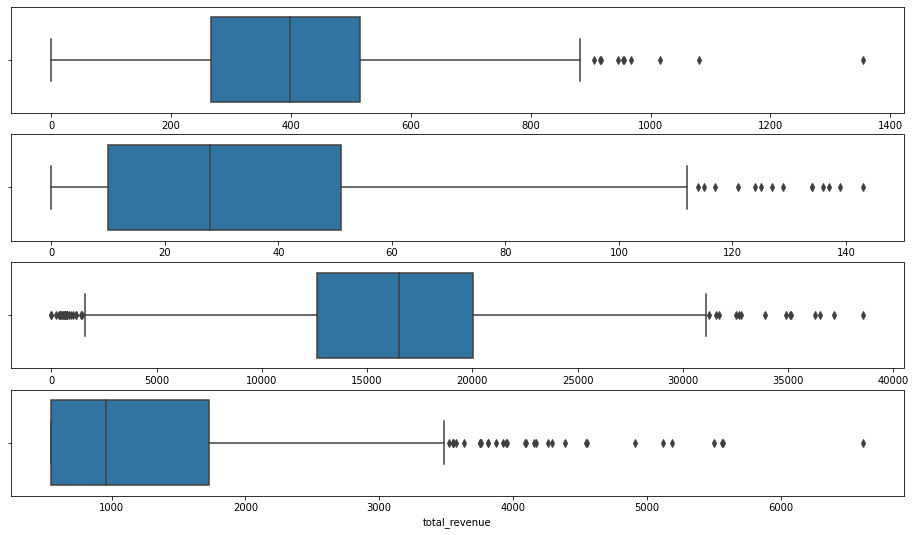

In [ ]:
count = 0
for columns in calls_messages_internet_analysis_smart:
    columnSeriesObj = calls_messages_internet_analysis_smart[columns]
    if columnSeriesObj.dtypes != object:
            count +=1
fig,axes=plt.subplots(count, figsize=(16,9))

counter = -1
for columns in calls_messages_internet_analysis_smart:
    columnSeriesObj = calls_messages_internet_analysis_smart[columns]
    if columnSeriesObj.dtypes != object:
        counter += 1
        try:
            sns.boxplot(x=columnSeriesObj, ax=axes[counter])
        except:
            sns.boxplot(x=columnSeriesObj, ax=axes[counter], kde=False)

Определим характерный разброс, построив диаграммы межквартильного размаха для тарифа ultra

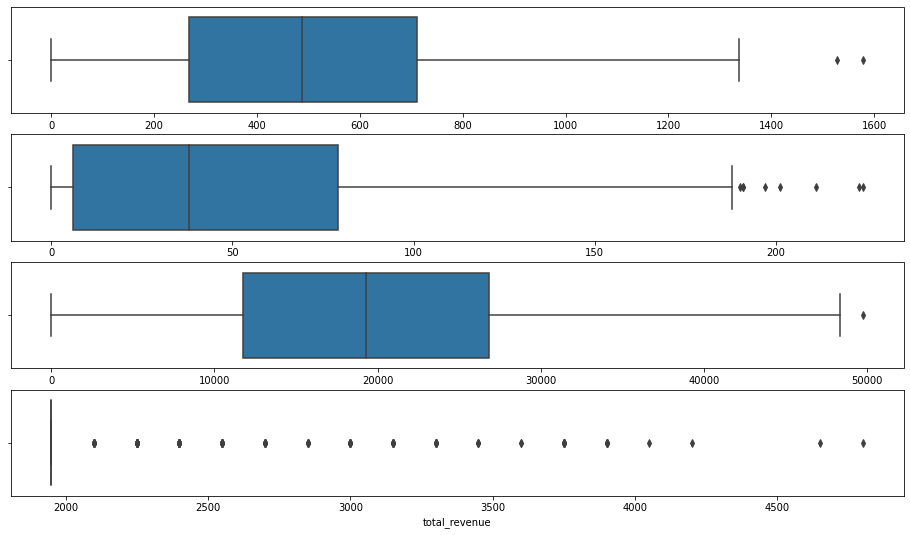

In [ ]:
count = 0
for columns in calls_messages_internet_analysis_ultra:
    columnSeriesObj = calls_messages_internet_analysis_ultra[columns]
    if columnSeriesObj.dtypes != object:
            count +=1
fig,axes=plt.subplots(count, figsize=(16,9))

counter = -1
for columns in calls_messages_internet_analysis_ultra:
    columnSeriesObj = calls_messages_internet_analysis_ultra[columns]
    if columnSeriesObj.dtypes != object:
        counter += 1
        try:
            sns.boxplot(x=columnSeriesObj, ax=axes[counter])
        except:
            sns.boxplot(x=columnSeriesObj, ax=axes[counter], kde=False)

### Вывод  

**Параметры среднестатистической пользователя тарифа smart (выборка из 351 чел.):**
 - количество использованных минут, шт.: 395 (79% лимита тарифного плата)
 - количество использованных сообщений, шт.: 33 (66% лимита тарифного плата)
 - объем использованного интернет-траффика, Мб.: 16208 (108% лимита тарифного плата)
 - средний расход на услуги связи, руб. : 1258 (228 % стоимости тарифа)

**Параметры среднестатистической пользователя тарифа ultra (выборка из 149 чел.):**
 - количество использованных минут, шт.: 498 (16% лимита тарифного плата)
 - количество использованных сообщений, шт.: 49 (5% лимита тарифного плата)
 - объем использованного интернет-траффика, мб.: 19469 (64% лимита тарифного плата)
 - средний расход на услуги связи, руб. : 2070 (94 % стоимости тарифа)
  
  

**Анализ гистограмм и диаграмм межквартильного размаха**:  

`Анализ тарифа smart`
 - minutes_used: график похож на нормальное распределение, большинство значений находятся в диапазоне от 267 до 515 минут. Выбросы начинаются после 900 минут. На среднее не влияют.
 - messages_used: график похож на нормальное распределение, но датасет немного скошен вправо - на среднее значение влияет большое количество месяцев, когда пользователи практически не отправляли смс. большинство значений находятся в диапазоне от 10 до 50 смс. Выбросы начинаются после 110 смс.
 - mb_used: график похож похож на нормальное распределение, большинство значений находятся в диапазоне от 12 до 20 гб. Выбросы есть до 2,5 гб. и после 32 гб. На среднее не влияют.
 - total_revenue: график похож на нормальное распределение, всплеск виден у значения 550 (много пользователей укладываются в лимиты). Большинство значений находятся в интервале 900 - 1700 р (переплачивают за услуги). Выбросы начинаются после 3500 р. На среднее не влияют.

`Анализ тарифа ultra`
 - minutes_used: график похож на нормальное распределение, большинство значений находятся в диапазоне от 267 до 711 минут. Выбросы начинаются после 1370 минут. На среднее не влияют.
 - messages_used: график похож на нормальное распределение, но датасет немного скошен вправо - на среднее значение влияет большое количество месяцев, когда пользователи практически не отправляли смс. большинство значений находятся в диапазоне от 6 до 80 смс. Выбросы начинаются после 180 смс.
 - mb_used: график похож похож на нормальное распределение, большинство значений находятся в диапазоне от 12 до 27 гб. Выбросы начинаются после 48 гб. На среднее не влияют.
 - total_revenue: график НЕ ПОХОЖ на нормальное распределение, всплеск у значения 1950 р (абслолютное большинство пользователей укладываются в лимиты). Выбросы начинаются после 3450 р. На среднее не влияют.

**Общий вывод**: пользователи тарифного плана smart в месяц в среднем выговаривают на 103 минут меньше, чем пользователь тарифа ultra (395 и 498 минут соответственно), отправляют на 16 смс меньше (33 - 49 смс), потребляют практически равное количество (~ 20 Гб) интернет траффика при схожих расходах на связь (1250р у тарифыа smart, 2000р у тарифа ultra ). В тарифе smart основным источником перерасхода является интернет. Равно, как и в тарифе ultra (но у небольшого числа абонентов).
Снизив потребление интернета на 5 гигабайт, среднестатистический пользователь мог бы в 2,5 раза снизить траты на услуги мобильной связи (перейти на тариф smart).

## Шаг 4. Проверьте гипотезы


### Проверим гипотезу, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.  
 - Сформулируем нулевую гипотезу H₀ - "средняя выручка пользователей тарифов «Ультра» и «Смарт» равна";
 - Альтернативная гипотеза H₁ - "средняя выручка пользователей тарифов «Ультра» и «Смарт» не равна".


Применим гипотезу о равенстве средних двух генеральных совокупностей

In [ ]:
# средняя выручка пользователей тарифа smart
total_revenue_smart = calls_messages_internet_analysis_smart['total_revenue']

# средняя выручка пользователей тарифа ultra
total_revenue_ultra = calls_messages_internet_analysis_ultra['total_revenue']

alpha = 0.05 # зададим критический уровень статистической значимости

results = st.ttest_ind(
    total_revenue_smart,
    total_revenue_ultra) # проверим гипотезу о равенстве средних двух независимых совокупностей

print('p-значение:', results.pvalue) # выведем на экран получившеся p-значение

if (results.pvalue < alpha): # сравним получившееся p-значение с заданным уровнем статистической значимости
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 8.813878364275262e-179
Отвергаем нулевую гипотезу


#### Вывод:  
 - Нулевую гипотезу отвергаем - средняя выручка пользователей тарифов «Ультра» и «Смарт» различны.

### Проверим гипотезу, средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
 - Сформулируем нулевую гипотезу H₀ - "средняя выручка пользователей из Москвы и пользователей из других регионов равна";
 - Альтернативная гипотеза H₁ - "средняя выручка пользователей из Москвы и пользователей из других регионов не равна".

Для этого создадим совмещенную таблицу `total_revenue_city` с полями **user_id, city_id и total_revenue**

In [ ]:
user_id_total_revenue = calls_messages_internet[['user_id', 'total_revenue']]
user_id_total_revenue_city = user_id_total_revenue.merge(users_updated[['user_id', 'city_id']], on='user_id', how='left')

Определим city_id для Москвы из словаря `city_dict`

In [ ]:
display(city_dict.query('city == "Москва"'))

,city,city_id
31,Москва,31


Создадим таблицы, отфильтрованные по значению **Москва** и **не Москва**


In [ ]:
user_id_total_revenue_city_moscow = user_id_total_revenue_city.query('city_id == 31')
user_id_total_revenue_city_others = user_id_total_revenue_city.query('city_id != 31')

In [ ]:
# средняя выручка пользователей Москвы
total_revenue_moscow = user_id_total_revenue_city_moscow['total_revenue']

# средняя выручка пользователей других населенных пунктов
total_revenue_others = user_id_total_revenue_city_others['total_revenue']

alpha = 0.05 # зададим критический уровень статистической значимости

results = st.ttest_ind(
    total_revenue_moscow,
    total_revenue_others) # проверим гипотезу о равенстве средних двух независимых совокупностей

print('p-значение:', results.pvalue) # выведем на экран получившееся p-значение

if (results.pvalue < alpha): # сравним получившееся p-значение с заданным уровнем статистической значимости
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.48244885168123475
Не получилось отвергнуть нулевую гипотезу


#### Вывод:  
Не получилось отвергнуть нулевую гипотезу. Полученное значение p-value говорит о том, что хотя средняя выручка от пользователей из Москвы и других городов неодинакова (1990р и 2022р), с вероятностью в почти 48% такое или большее различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средней выручкой.

## Шаг 5. Общий вывод:

После проведения анализа ясно, что данные были достаточно корректны. Имеющиеся выбросы практически не влияли на полученные результаты.

Параметры среднестатистической пользователя тарифа smart (выборка из 351 чел.):
 - количество использованных минут, шт.: 395 (79% лимита тарифного плата). Большинстко пользователей потребляют от 355 до 675 минут ежемесячно.
 - количество использованных сообщений, шт.: 33 (66% лимита тарифного плата). Большинстко пользователей отсылают от 10 до 50 смс ежемесячно, хотя бывает, что в некоторые месяцы смс пользуются минимально.
 - объем использованного интернет-траффика, Мб.: 16208 (108% лимита тарифного плата). Большинство пользователей потребляет от 15 до 25 гб в месяц.
 - средний расход на услуги связи, руб. : 1258 (228 % стоимости тарифа). Многие укладываются в 550 р, но в среднем большинство пользователей платит от 900 до 2700р (переплачивают за услуги).


Параметры среднестатистической пользователя тарифа ultra (выборка из 149 чел.):
 - количество использованных минут, шт.: 498 (16% лимита тарифного плата). Большинстко пользователей потребляют от 355 до 923 минут ежемесячно.
 - количество использованных сообщений, шт.: 49 (5% лимита тарифного плата). Большинстко пользователей отсылают от 6 до 80 смс ежемесячно, хотя бывает, что в некоторые месяцы смс пользуются минимально.
 - объем использованного интернет-траффика, мб.: 19469 (64% лимита тарифного плата). Большинство пользователей потребляет от 12 до 28 гб в месяц.
 - средний расход на услуги связи, руб. : 2070 (94 % стоимости тарифа).
 - Абслоютное большинство пользователей платит стандартные 1950р и полностью укладываются в лимиты тарифного плана.


Мы отвергли нулевую гипотезу, что средняя выручка пользователей тарифов «Ультра» и «Смарт» равна;
У нас не получилось отвергнуть нулевую гипотезу, что средняя выручка пользователей из Москвы и пользователей из других регионов равна.

**Дополнительные выводы**:
- пользователи тарифного плана smart в месяц в среднем выговаривают на 103 минут меньше, чем пользователь тарифа ultra (395 и 498 минут соответственно), отправляют на 16 смс меньше (33 - 49 смс), по потребляют практически равное количество (~ 20 Гб) интернет траффика при схожих расходах на связь (1250р у тарифыа smart, 2000р у тарифа ultra). В тарифе smart основным источником перерасхода является интернет. Равно, как и в тарифе ultra (но у небольшого числа абонентов). Снизив потребление интернета на 5 гигабайт, среднестатистический пользователь мог бы в 2,5 раза снизить траты на услуги мобильной связи (перейти на тариф smart).

На основе полученных данных, делаем вывод, что приносит больше денег тариф smart (пользователи меньше говорят, отправляют смс и пользуются интернетом, но платят, в среднем, как по тарифу ultra).